# LSTM-CNN

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 84.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 107.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 21.1 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [ ]:
import pickle
import numpy as np
import os
import torchvision
import torch.utils.data
import torchvision.transforms as T
import matplotlib.pyplot as plt
import torch
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchsummary import summary
from torchvision import datasets,models
from torch.utils.data import random_split,Dataset
from torch.utils.data.sampler import SubsetRandomSampler
import copy
from PIL import Image

In [ ]:
os.makedirs('dai', exist_ok=True)
!tar -xzf /content/drive/MyDrive/CrisisMMD_v2.0.tar.gz -C dai
!unzip -d dai/CrisisMMD_v2.0/crisismmd_datasplit_all dai/CrisisMMD_v2.0/crisismmd_datasplit_all.zip
!rm -rf crisismmd_datasplit_all

Archive:  dai/CrisisMMD_v2.0/crisismmd_datasplit_all.zip
   creating: dai/CrisisMMD_v2.0/crisismmd_datasplit_all/crisismmd_datasplit_all/
  inflating: dai/CrisisMMD_v2.0/crisismmd_datasplit_all/__MACOSX/._crisismmd_datasplit_all  
  inflating: dai/CrisisMMD_v2.0/crisismmd_datasplit_all/crisismmd_datasplit_all/task_informative_text_img_train.tsv  
  inflating: dai/CrisisMMD_v2.0/crisismmd_datasplit_all/__MACOSX/crisismmd_datasplit_all/._task_informative_text_img_train.tsv  
  inflating: dai/CrisisMMD_v2.0/crisismmd_datasplit_all/crisismmd_datasplit_all/task_damage_text_img_train.tsv  
  inflating: dai/CrisisMMD_v2.0/crisismmd_datasplit_all/__MACOSX/crisismmd_datasplit_all/._task_damage_text_img_train.tsv  
  inflating: dai/CrisisMMD_v2.0/crisismmd_datasplit_all/crisismmd_datasplit_all/task_damage_text_img_test.tsv  
  inflating: dai/CrisisMMD_v2.0/crisismmd_datasplit_all/crisismmd_datasplit_all/task_informative_text_img_test.tsv  
  inflating: dai/CrisisMMD_v2.0/crisismmd_datasplit_all/

In [ ]:
from transformers import AutoTokenizer, VisualBertForPreTraining
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
# tokens = tokenizer(tweet, padding=True, return_tensors="pt",truncation=True,max_length=100)
# print(np.array(tokens['input_ids']).shape)
tokenizer.vocab_size


30522

In [ ]:
map={"california_wildfires":0,'srilanka_floods':1,'iraq_iran_earthquake':2,'hurricane_harvey':3,'mexico_earthquake':4}
class CrisisMMD(Dataset):
    def __init__(self, tsv_path, img_dir_path, transform=None):
        self.classes = ['california_wildfires', 'srilanka_floods', 'iraq_iran_earthquake', 'hurricane_harvey', 'mexico_earthquake']
        data = pd.read_csv(tsv_path, sep='\t')
        data = data[['image', 'event_name', 'tweet_text']]
        self.data = data.loc[data['event_name'].isin(self.classes)]
        self.transform = transform
        self.img_dir_path = img_dir_path

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        sample = self.data.iloc[idx]
        image = Image.open(f"{self.img_dir_path}/{sample['image']}")
        image = image.convert("RGB")
        if self.transform:
            image = self.transform(image)
        label = map[sample['event_name']]
        name_label =sample['event_name']
        tweet = sample['tweet_text']
        # tokens = tokenizer(tweet, padding=True, return_tensors="pt",truncation=True,max_length=30)
        return image, label, name_label,tweet

In [ ]:
data_dir = r'dai/CrisisMMD_v2.0'
tsv_dir = data_dir + r'/crisismmd_datasplit_all/crisismmd_datasplit_all'

transform = T.Compose([T.Resize((224, 224)), T.ToTensor(), T.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

train_set = CrisisMMD(f'{tsv_dir}/task_humanitarian_text_img_train.tsv', data_dir, transform=transform)
val_set = CrisisMMD(f'{tsv_dir}/task_humanitarian_text_img_dev.tsv', data_dir, transform=transform)
test_set = CrisisMMD(f'{tsv_dir}/task_humanitarian_text_img_test.tsv', data_dir, transform=transform)

In [ ]:
# Define the training and test data loaders
def make_loaders(train_set,test_set,batch_size):
  trainloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
  testloader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True)
  return trainloader,testloader

torch.Size([32, 3, 224, 224])
('hurricane_harvey', 'hurricane_harvey', 'mexico_earthquake', 'hurricane_harvey', 'hurricane_harvey', 'hurricane_harvey', 'hurricane_harvey', 'california_wildfires', 'mexico_earthquake', 'hurricane_harvey', 'hurricane_harvey', 'hurricane_harvey', 'hurricane_harvey', 'california_wildfires', 'mexico_earthquake', 'mexico_earthquake', 'mexico_earthquake', 'hurricane_harvey', 'california_wildfires', 'hurricane_harvey', 'hurricane_harvey', 'hurricane_harvey', 'hurricane_harvey', 'hurricane_harvey', 'california_wildfires', 'california_wildfires', 'california_wildfires', 'california_wildfires', 'hurricane_harvey', 'california_wildfires', 'hurricane_harvey', 'hurricane_harvey')
tensor([3, 3, 4, 3, 3, 3, 3, 0, 4, 3, 3, 3, 3, 0, 4, 4, 4, 3, 0, 3, 3, 3, 3, 3,
        0, 0, 0, 0, 3, 0, 3, 3])
("RT @Micah_McHenry: Harvey destroyed Dairy Treet. I'm officially pissedὡ2 https://t.co/7biA2Xj9vL", '#bitcoin, Cherch of Blerk, and Brave Volunteers Connect During the Destructio

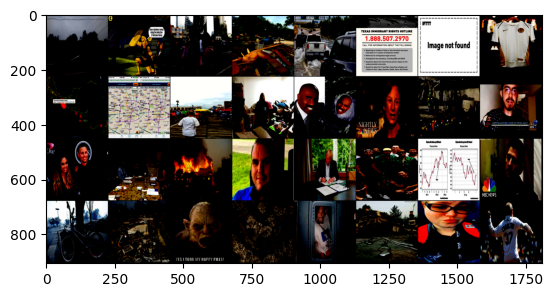

In [ ]:
trainloader,testloader=make_loaders(train_set,test_set,32)
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


dataiter = iter(testloader)
images, labels ,name_labels, tweet = next(dataiter)

print(images.shape)
print(name_labels)
print(labels)
print(tweet)
# show images
imshow(torchvision.utils.make_grid(images))

In [ ]:
device = torch.device("cuda")

In [ ]:
tokens = tokenizer(tweet, padding="max_length", return_tensors="pt",truncation=True,max_length=100)
print(np.array(tokens['input_ids']).shape)


final_tweet=torch.tensor(np.array(tokens['input_ids']).T).to(device)
print(final_tweet.shape)

# print(final_tweet)

(32, 100)
torch.Size([100, 32])


In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, num_layers, dropout, bidirectional = False):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding(input_size, embedding_size)
        self.lstm = nn.LSTM(embedding_size, hidden_size, num_layers, dropout=dropout, bidirectional=bidirectional)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # print('encoder---------------------------')
        embedding = self.dropout(self.embedding(x))
        # print('embed', embedding.shape)
        outputs, (hidden, cell) = self.lstm(embedding)
        # print("outputs", outputs.shape)
        # print("hid", hidden.shape)
        # print("cell", cell.shape)
        return outputs, hidden, cell

In [ ]:
def getModel():
  # Load the pre-trained ResNet18 model
  model = models.vgg16(pretrained=True)


  # Replace the last fully connected layer to fit our task
  num_ftrs = model.classifier[6].in_features
  model.classifier[6] = nn.Linear(num_ftrs, 128) 
  return model

In [ ]:
class LSTM_CNN(nn.Module):
    def __init__(self, encoder,vgg):
        super(LSTM_CNN, self).__init__()
        self.encoder=encoder
        self.vgg=vgg
        self.fc= torch.nn.Sequential(
                                    torch.nn.Linear(256, 128),
                                    torch.nn.ReLU(),
                                    torch.nn.Linear(128,64),
                                    torch.nn.ReLU(),
                                    torch.nn.Linear(64, 32),
                                    torch.nn.ReLU(),
                                    torch.nn.Linear(32, 5)
                                    # torch.nn.Softmax(dim=1)
                                    )
        
    def forward(self,images,tweets):
        _,_,text_embedding=self.encoder(tweets)
        text_embedding = text_embedding.squeeze(dim=0)
        # print("=================",text_embedding.shape)


        img_embedding=self.vgg(images)

        final=torch.cat((text_embedding,img_embedding), dim=1)

        final=self.fc(final)

        return final

In [ ]:
encoder = Encoder(40000, 1024, 128,1,0)

In [ ]:
vgg=getModel()


/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
model=LSTM_CNN(encoder,vgg).cuda()
optimiser = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
loss_function = torch.nn.CrossEntropyLoss().to(device)
def train(epoch,model,optimiser):  # give the epochs, model you want to train and optimiser

  trainLoss=[]
  testLoss=[] 
  trainAcc=[]
  testAcc=[]
  for i in range(epoch):
    model.train()
    train_loss=0
    train_acc=0

    for batch_idx,(img, labels ,name_labels, tweet ) in enumerate(trainloader):

      img=img.cuda()
      # # print(data)
      labels = labels.cuda()
      # # print(labels)

      tokens = tokenizer(tweet,  padding="max_length", return_tensors="pt",truncation=True,max_length=100)

      final_tweet=torch.tensor(np.array(tokens['input_ids']).T).cuda()
      
      optimiser.zero_grad()
      output=model(img,final_tweet)
      # print(recon_batch)

      loss=loss_function(output,labels)

      preds = torch.argmax(output, dim=1)
      train_acc += sum(preds.detach().cpu().numpy() == labels.detach().cpu().numpy())

      # print(loss)
      loss.backward()
      train_loss+=loss.item()
      optimiser.step()

      if batch_idx==390 :
        print('Train Epoch   {}  : Batch id : {}  '.format(i+1,batch_idx))
    

    print('======> Epoch :{} Train Loss : {:.6f}'.format(i+1,train_loss/len(trainloader.dataset)))
    trl=train_loss/len(trainloader.dataset)
    trainLoss.append(trl)
    
    train_acc = train_acc/len(trainloader.dataset)
    print("                  Train Accuracy: {:.6f} ".format(train_acc))
    trainAcc.append(train_acc)

    test_loss,test_acc=test(model)

    testLoss.append(test_loss)
    testAcc.append(test_acc)

  return model,trainLoss,testLoss,trainAcc,testAcc

def test(model):
  model.eval()
  test_loss=0
  test_acc=0

  with torch.no_grad():
    for i,(imag, label ,name_labels, tweet ) in enumerate(testloader):

      imag=imag.cuda()
      label = label.cuda()
      tokens = tokenizer(tweet,padding="max_length", return_tensors="pt",truncation=True,max_length=100)
      final_tweet=torch.tensor(np.array(tokens['input_ids']).T).cuda()


      output=model(imag,final_tweet)
      test_loss+=loss_function(output,label).item()

      preds = torch.argmax(output, dim=1)

      test_acc += sum(preds.detach().cpu().numpy() == label.detach().cpu().numpy())


  test_loss/=len(testloader.dataset)
  test_acc/=len(testloader.dataset)


  print('=====> Test set loss : {:.6f}'.format(test_loss))
  print("       Test Accuracy: {:.6f} ".format(test_acc))

  return test_loss,test_acc

In [ ]:
model,trainLoss1,testLoss1,trainAcc1,testAcc1=train(10,model,optimiser)

/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


======> Epoch :1 Train Loss : 0.048942
                  Train Accuracy: 0.492979 
=====> Test set loss : 0.043628
       Test Accuracy: 0.493103 
======> Epoch :2 Train Loss : 0.043115
                  Train Accuracy: 0.493274 
=====> Test set loss : 0.043863
       Test Accuracy: 0.493103 
======> Epoch :3 Train Loss : 0.031104
                  Train Accuracy: 0.601626 
=====> Test set loss : 0.022845
       Test Accuracy: 0.718103 
======> Epoch :4 Train Loss : 0.011500
                  Train Accuracy: 0.853659 
=====> Test set loss : 0.007388
       Test Accuracy: 0.926724 
======> Epoch :5 Train Loss : 0.003371
                  Train Accuracy: 0.970140 
=====> Test set loss : 0.006763
       Test Accuracy: 0.935345 
======> Epoch :6 Train Loss : 0.001526
                  Train Accuracy: 0.988027 
=====> Test set loss : 0.005324
       Test Accuracy: 0.952586 
======> Epoch :7 Train Loss : 0.000993
                  Train Accuracy: 0.994087 
=====> Test set loss : 0.006598
   

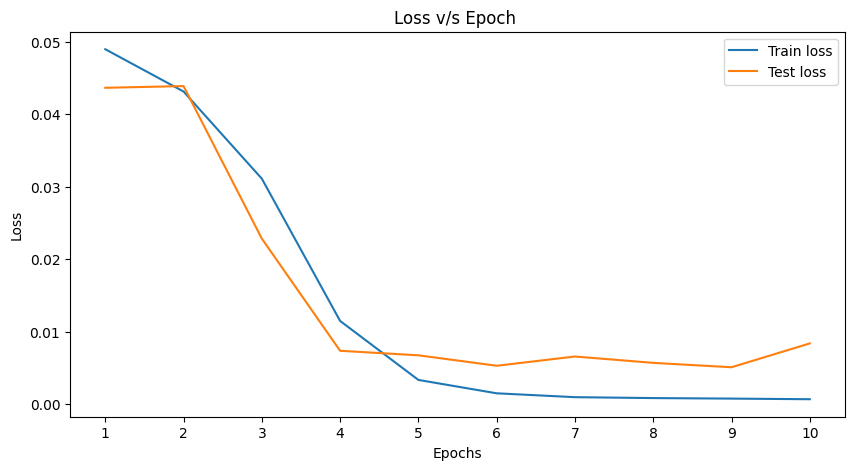

In [ ]:
plt.figure(figsize=(10,5))
epochArr=[i for i in range(1,11)]
plt.plot(epochArr,trainLoss1)
plt.plot(epochArr,testLoss1)
plt.xticks(epochArr)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss v/s Epoch ")
plt.legend(["Train loss","Test loss"])
plt.show()

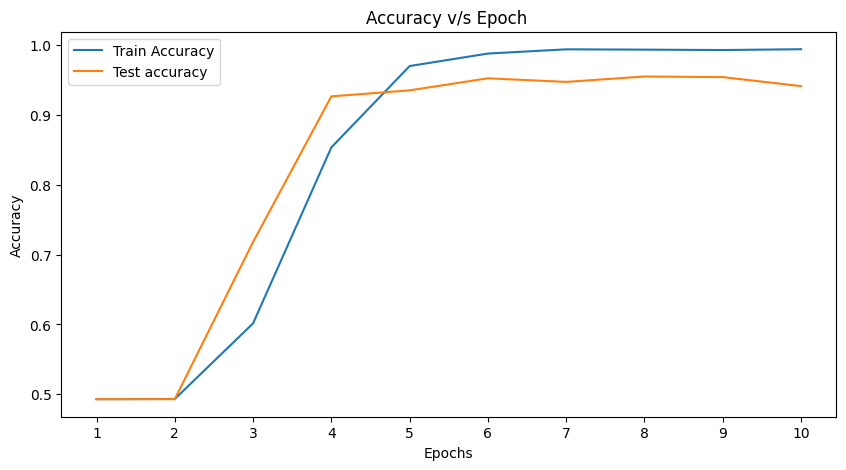

In [ ]:
plt.figure(figsize=(10,5))
epochArr=[i for i in range(1,11)]
plt.plot(epochArr,trainAcc1)
plt.plot(epochArr,testAcc1)
plt.xticks(epochArr)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy v/s Epoch ")
plt.legend(["Train Accuracy","Test accuracy"])
plt.show()